In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
data_dir = './mnist_data/'
propn_sample = 0.01

In [3]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [4]:
batchsize = 10

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [5]:
len(train_loader.dataset)

600

In [6]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [7]:
slen = data_train['image'].shape[-1]

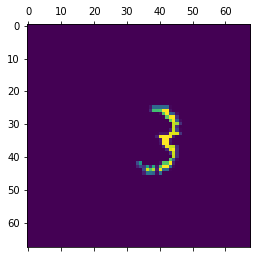

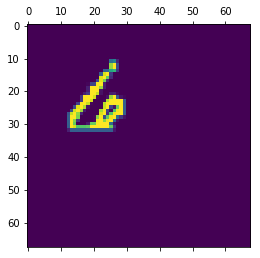

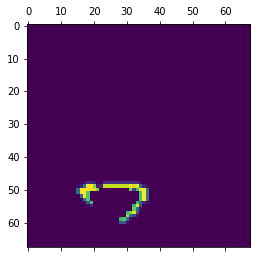

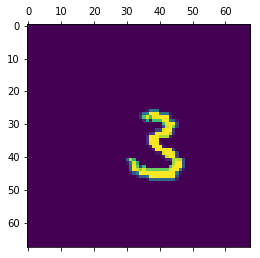

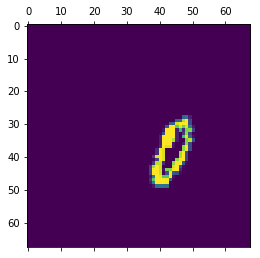

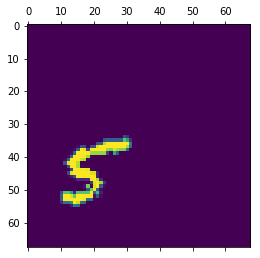

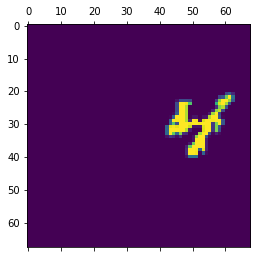

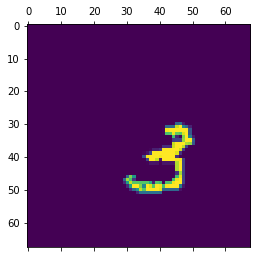

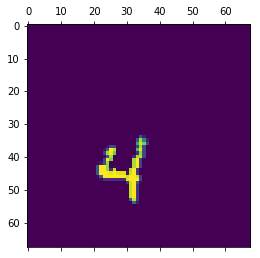

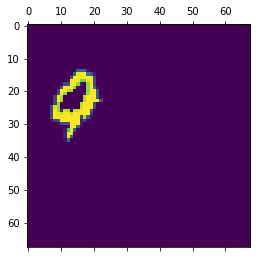

In [8]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [9]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [10]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [11]:
vae_file = './mnist_vae_results/moving_mnist_vae_nsamples6_epoch20'
# vae_file = './mnist_vae_results/moving_mnist_vae_nsamples6_epoch80'

moving_mnist_vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

moving_mnist_vae.eval()

MovingHandwritingVAE(
  (mnist_vae): HandwritingVAE(
    (encoder): MLPEncoder(
      (fc1): Linear(in_features=841, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=10, bias=True)
      (tanh): Tanh()
    )
    (decoder): MLPDecoder(
      (fc1): Linear(in_features=5, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=841, bias=True)
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
  )
  (pixel_attention): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
    )
    (fc1): Linear(in_features=3600, out_features=4624, bias=True)
    (log_softmax): LogSoftmax()
  )
)

# Check losses

In [12]:
train_loss = vae_training_lib.eval_vae(moving_mnist_vae, train_loader, train = False,
                            set_true_loc = False)

print(train_loss)

tensor(178.8309)


In [13]:
images_debugging = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6images_debugging.npy')
images_debugging = torch.Tensor(images_debugging)

In [14]:
moving_mnist_vae.get_rb_loss(images_debugging, n_samples = 0)[1] / images_debugging.shape[0]

tensor(175.8878)

# Check reconstructions 

In [15]:
use_images_debugging = True
if use_images_debugging: 
    image = images_debugging

In [16]:
log_pixel_probs = moving_mnist_vae.pixel_attention(image)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f23f7bbab38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f23f7b4b438>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f23f7bba9e8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f23f7b4bc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f23f7b520f0>],
 'means': []}

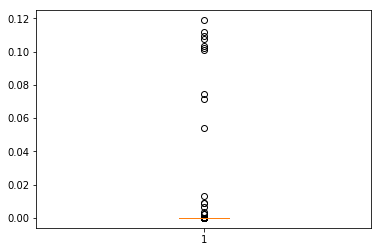

In [17]:
plt.boxplot(torch.exp(log_pixel_probs[4, :].detach()))

In [18]:
map_pixel_1d = torch.argmax(log_pixel_probs, dim=1)

In [19]:
use_true_loc = False
if use_true_loc: 
    map_pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)
    
recon_means = moving_mnist_vae.forward_cond_pixel_1d(image, map_pixel_1d)[0]

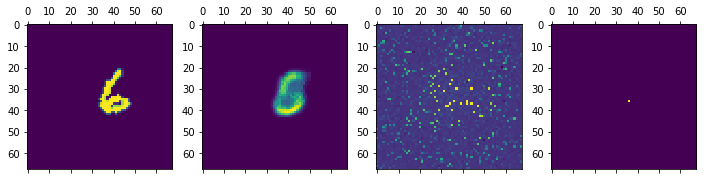

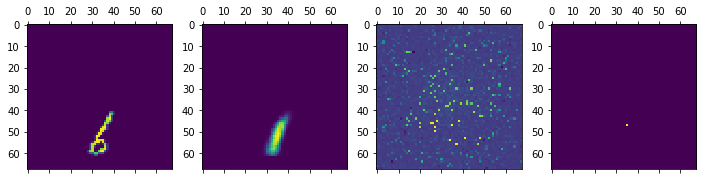

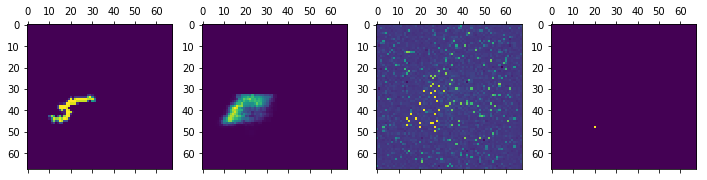

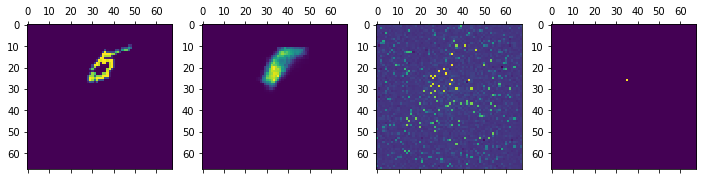

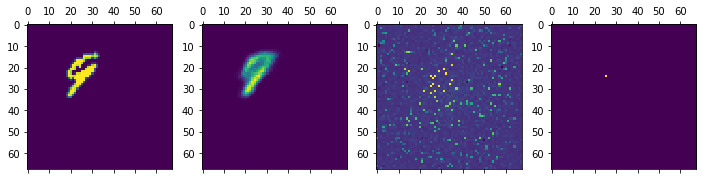

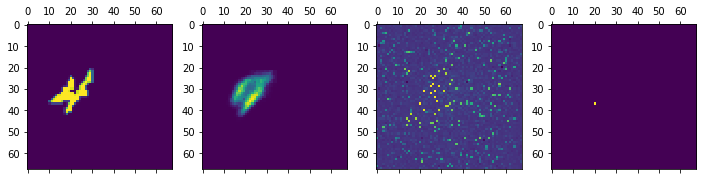

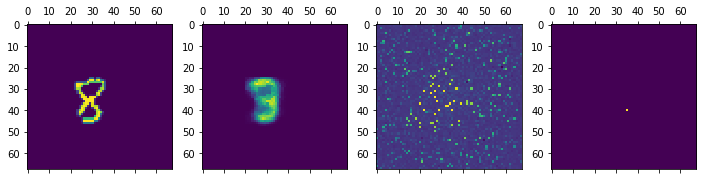

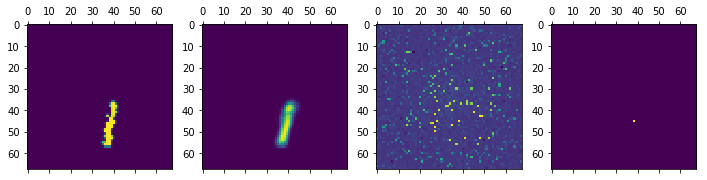

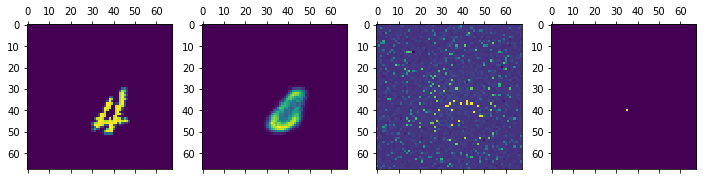

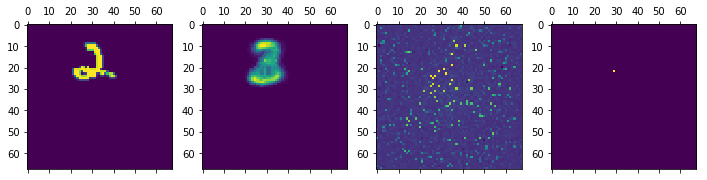

In [25]:
# printing the map locations 
loc_plots = torch.zeros(recon_means.shape)
map_pixel_2d = mnist_data_utils.pixel_1d_to_2d(sout = 68, padding = 0, pixel_1d = map_pixel_1d)

for i in range(0, 10): 
    
    _, axarr = plt.subplots(1, 4, figsize=(12, 12))
    
    # image and reconstruction 
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(recon_means[i, 0, :, :].detach())
    
    # location distributions 
    axarr[2].matshow(torch.t(log_pixel_probs[i, :].view(68, 68).detach()))
    
    # map location 
    loc_plots[i, 0, map_pixel_2d[i, 1], map_pixel_2d[i, 0]] = 1
    axarr[3].matshow(loc_plots[i, 0, :, :])

In [21]:
# batch_losses = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_batch_losses.npy')

In [22]:
batch_losses_rb = np.load('./mnist_vae_results/moving_mnist_vae_topk5_batch_losses.npy')

In [23]:
batch_losses_resample = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_batch_losses.npy')

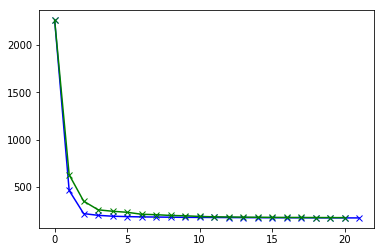

In [24]:
# plt.plot(batch_losses, 'r-x'); 
plt.plot(batch_losses_rb, 'b-x'); 
plt.plot(batch_losses_resample, 'g-x');

In [60]:
batch_losses_resample

array([2260.776  ,  370.37668,  207.71242,  198.93806,  193.23955,
        190.09007,  187.05656,  185.89844,  184.44894,  183.87291,
        181.58092,  181.34381,  181.85957,  180.22208,  179.60533,
        179.5799 ,  178.54073,  178.60583,  178.05928,  178.25128,
        177.43886,  176.47472,  176.04227,  175.29405,  174.9689 ,
        174.97005,  175.19554,  174.85258,  174.02472,  174.72733,
        173.66919,  173.8042 ,  174.55623,  173.1379 ,  173.9121 ,
        173.99545,  173.37396,  173.05771,  173.03047,  172.61296,
        173.14384,  173.16116,  172.84264,  173.45007], dtype=float32)

In [38]:
test_losses = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_test_losses.npy')

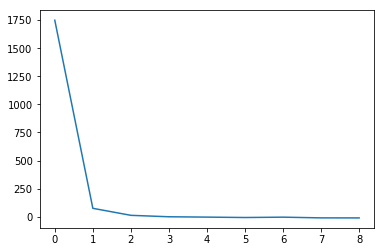

In [39]:
plt.plot(test_losses)